In [1]:
%load_ext autoreload
%autoreload 2

In [7]:

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["JAX_ENABLE_X64"] = "True"


import jax.numpy as jnp
import numpy as np
import pytest
from jax import random

import matplotlib.pyplot as plt 

from bpd.pipelines.shear_inference import pipeline_shear_inference_ellipticities
from bpd.pipelines.toy_ellips import pipeline_toy_ellips_samples

In [18]:
key = random.key(43)
k1, k2 = random.split(key)

g1 = 0.02
g2 = 0.0
sigma_e = 1e-3
sigma_m = 1e-4
sigma_e_int = 4e-2  # should be larger than sheared elliptcity magnitude
true_g = jnp.array([g1, g2])
n_gals = 1000

In [19]:
e_post, _, e_sheared = pipeline_toy_ellips_samples(
    k1,
    g1=g1,
    g2=g2,
    sigma_e=sigma_e,
    sigma_e_int=sigma_e_int,
    sigma_m=sigma_m,
    n_gals=n_gals,
    n_samples_per_gal=100,
)
assert e_post.shape == (n_gals, 100, 2)
e_post_trimmed = e_post[:, ::10, :]

In [20]:
shear_samples = pipeline_shear_inference_ellipticities(
    k2,
    e_post_trimmed,
    init_g=true_g,
    sigma_e=sigma_e,
    sigma_e_int=sigma_e_int,
    n_samples=1000,
    initial_step_size=1e-3,
)

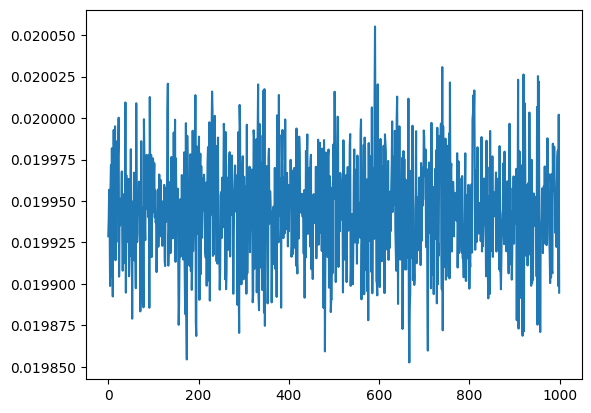

In [21]:
plt.plot(shear_samples[:, 0])

In [23]:
std_e1 = e_sheared[:, 0].std()
std_e2 = e_sheared[:, 1].std()
g1_std = jnp.std(shear_samples[:, 0])
g2_std = jnp.std(shear_samples[:, 1])

In [24]:
(shear_samples[:, 0].mean() - 0.02) / 0.02

Array(-0.00278928, dtype=float64)

In [25]:
assert shear_samples.shape == (1000, 2)
assert jnp.abs((jnp.mean(shear_samples[:, 0]) - g1) / g1) <= 3e-3
assert jnp.abs(jnp.mean(shear_samples[:, 1])) <= 3e-3

In [26]:
g1_std, std_e1 / jnp.sqrt(1000)

(Array(3.24174187e-05, dtype=float64), Array(3.18468088e-05, dtype=float64))

In [27]:
assert np.allclose(g1_std, std_e1 / jnp.sqrt(n_gals), rtol=0.05, atol=0)
assert np.allclose(g2_std, std_e2 / jnp.sqrt(n_gals), rtol=0.05, atol=0)